# DP1 - Control Moment Gyroscope
AE 353 - Spring 22 

Cecilia Kim & Bella Watters

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# Modules from other external python libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import sympy as sym
from sympy.physics import mechanics
from scipy import linalg

# Given ae353 class script
import ae353_cmg

# force notebook to reimport script to account for changes to ae353_cmg
import importlib
importlib.reload(ae353_cmg)

<module 'ae353_cmg' from '/Users/bellawatters/Documents/ae353-sp22/projects/01_cmg/ae353_cmg.py'>

## Linearization

We will linearize the system using a state-space model.

Given the following EOMs, 

$$\dot{v}_1 = \frac{a_1 \sin(2q_2) v_1}{a_4 + a_5 \cos^{2}(q_2)} \\
  \dot{v}_2= a_6\sin(2q_2) v_1^2 + a_7\cos(q_2)v_1 v_{rotor}+ a_8 \tau$$

Our state is defined, 
$$x = \left[\begin{matrix}q_1 - q_{1,e}\\q_2 - q_{2,e}\\v_1 - v_{1,e}\\v_2 - v_{2,e}\end{matrix}\right]$$

To convert the model to a state-space format, $\dot{x} = Ax +Bu$, we must solve for the A & B matrices.

First, we create our symbolic parameters and define our constants.

In [2]:
# define symbols
q1, q2, v1, v2, tau = sym.symbols('q1, q2, v1, v2, tau')

# define constants (for symbolic solving)
# This code will generate the A & B matrices in terms of the a constants
#a1, a2, a3, a4, a5, a6, a7, a8, v_rotor = sym.symbols('a1, a2, a3, a4, a5, a6, a7, a8, v_rotor')

# define given constant (for numeric solving)
# this code will geneate the A & B matrices numerically
J1z           = 0.5           # kg * m^2
J2z           = 0.001         # kg * m^2
J2x           = 0.001         # kg * m^2
J3x           = 0.01          # kg * m^2
J3y           = 0.01          # kg * m^2
J3z           = 0.01          # kg * m^2
m             = 1.0           # kg
r             = 2.0           # m
g             = 9.81          # m/s^2
v_rotor       = 1000          # rad/s


# define a constants
a1 = -J3y + 2*J3z
a2 = 2*J3y
a3 = -2*g*m*r
a4 = 2*J1z + 2*J2z + 2*m*r**2
a5 = 2*J3z
a6 = (J3y - J3z)/(2 * (J2x + J3x))
a7 = -J3y/(J2x + J3x)
a8 = 1/(J2x + J3x)

Our chosen equilibrium angle is 0 radians. Therefore, for $\dot{x}$ to equal 0, the equilibrium point must be defined as below.

In [3]:
# define equilibrium
q1e = 0.
q2e = 0.
v1e = 0.
v2e = 0.
taue = 0.

Define a function that takes an equilibrium point as a parameter and returns the appropriate A and B matrices.

In [4]:
# Accepts an equilibrium point and linearizes given EOMs around that point
def linearize_model(q1e, q2e, v1e, v2e, taue):
    q1, q2, v1, v2, tau = sym.symbols('q1, q2, v1, v2, tau')
    eq1 = (a1*sym.sin(2*q2)*v1*v2 + a2*sym.cos(q2)*v2*v_rotor + a3*sym.sin(q1)) / (a4 + a5*sym.cos(q2)**2)
    eq2 = a6*sym.sin(2*q2)*v1**2 + a7*sym.cos(q2)* v1 * v_rotor + a8 * tau

    # define state and input matrices
    f = sym.Matrix([[v1], [v2], [eq1], [eq2]])
    u = sym.Matrix([tau])

    # verify equilibrium point
    f_num = sym.lambdify([q1, q2, v1, v2, tau], f)
    if not np.allclose(f_num(q1e, q1e, v1e, v2e, taue), 0.):
        raise Exception('equilibrium point is invalid')
        
    # Find A and B in symbolic form
    A_sym = f.jacobian([q1, q2, v1, v2])
    B_sym = f.jacobian([tau])
    
    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([q1, q2, v1, v2, tau], A_sym)
    B_num = sym.lambdify([q1, q2, v1, v2, tau], B_sym)

    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(q1e, q2e, v1e, v2e, taue).astype(float)
    B = B_num(q1e, q2e, v1e, v2e, taue).astype(float)
    
    # Return A, B
    return A, B

# calculate A, B for our chosen equilibrium
A, B = linearize_model(q1e, q2e, v1e, v2e, taue)


## Finding a Gain Matrix

To find K matrices to test, the below code generates psuedo-randomized K values and tests their eigenvalues against the acceptance criteria.

In [5]:
# empty K matrix
K = np.array([[0, 0, 0, 0]])

# boolean describing whether a valid K matrix has been found
found = False

# lower and upper bounds for random generator
l = -2
h = 2

# generate randomized K values until an appropriate one is generated
## acceptance criteria - all eigenvalues have a negative real part and zero imaginary part
while(not found):
    K = np.array([[random.uniform(l, h), random.uniform(l, h), random.uniform(l, h), random.uniform(l, h)]])
    F = A - B @ K
    s = linalg.eigvals(F)
    if ((s.real < 0).all() and (s.imag == 0).all()):
        found = True

# print the K matrix and associated eigenvalues
print(K)
print(linalg.eigvals(F))


[[-0.78181785  0.04504286 -0.3394333   1.70912051]]
[-1.41590819e+02+0.j -1.35136903e+01+0.j -2.29530756e-01+0.j
 -4.05517406e-02+0.j]


After generating multiple K values from the code above and testing them in the simulation, we selected the most effective K matrix for further testing. It is defined below to avoid being over-written by the generator above.

In [6]:
# This is our chosen K val, generated above and saved for continued use
K = np.array([[ 0.43674177,  0.09294257, -2.99607407,  0.95393946]])
# print(K)

## Simulation

**Simulator code provided in class repository** 
https://github.com/tbretl/ae353-sp22/tree/main/projects/01_cmg

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `damping` (a non-negative floating-point number, default `0.`) is the coefficient of viscous friction at each joint;
* `load_mass` (a non-negative floating-point number, default `1.`) is the mass of the sphere attached to the platform;
* `roll` (an angle in radians, default `np.pi / 2`) is the roll angle of the ground.

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [7]:
#ONLY RUN ONCE!!!!!!
simulator = ae353_cmg.Simulator(
    display=True,
    damping=0.,
    load_mass=1.,
    roll=(np.pi / 2),
)

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently.

In [9]:
class Controller:
    def __init__(self):
        self.K = K
        self.q1e = q1e
        self.q2e = q2e
        self.v1e = v1e
        self.v2e = v2e
        self.taue = taue
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            gimbal_angle,
            gimbal_velocity,
            rotor_velocity
        ):
        
        #find state
        x = np.array([
            [platform_angle - self.q1e],
            [gimbal_angle - self.q2e],
            [platform_velocity - self.v1e],
            [gimbal_velocity - self.v2e]
        ])
        
        #find u, define u as -kx
        u = -self.K @ x
        
        # Define gimbal torque in terms of our input matrix
        gimbal_torque = u[0,0]
        # check torque type - debugging
        #print(gimbal_torque.dtype)
        
        return gimbal_torque

Create an instance of the controller.

In [10]:
controller = Controller()

Reset the simulator with given initial conditions. A low-level controller (separate from yours) will try to ensure that the rotor velocity remains constant.

In [15]:
simulator.reset(
    platform_angle=0.5,             # radians
    platform_velocity=0.5,           
    gimbal_angle=0.0,
    gimbal_velocity=0.,
    rotor_velocity=1000.,
)

Reset the controller.

In [16]:
controller.reset()

Choose a camera view (could be `simulator.camera_topview()` or `simulator.camera_sideview()`).

In [17]:
simulator.camera_topview()

Run the simulator.

In [18]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=30.0,        # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Get, show, and save a snapshot of the simulation after the last time step.

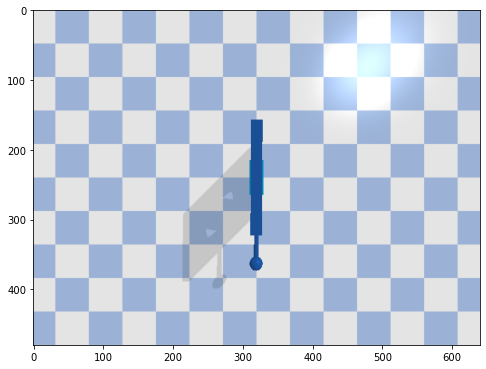

In [19]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

(-6.0, 6.0)

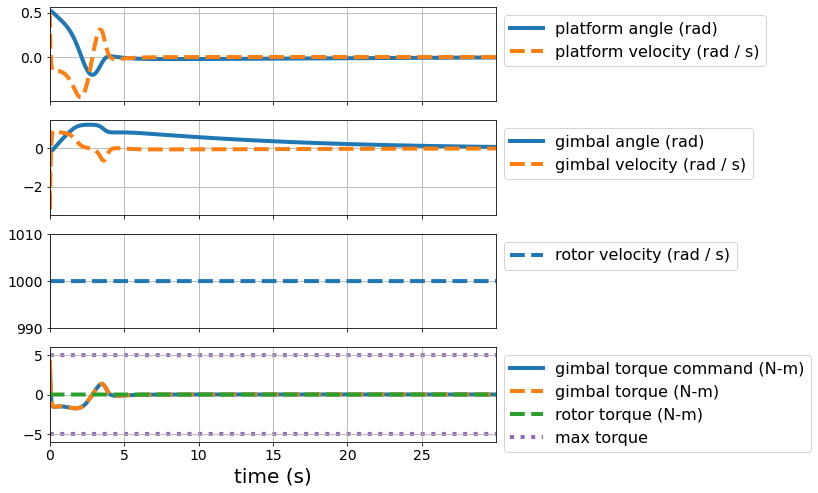

In [20]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_platform, ax_gimbal, ax_rotor, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot platform angle and velocity
ax_platform.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform.plot(
    data['t'], data['platform_velocity'],
    '--', label='platform velocity (rad / s)', linewidth=4,
)
ax_platform.grid()
ax_platform.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_platform.tick_params(labelsize=14)

# Plot gimbal angle and velocity
ax_gimbal.plot(
    data['t'], data['gimbal_angle'],
    label='gimbal angle (rad)', linewidth=4,
)
ax_gimbal.plot(
    data['t'], data['gimbal_velocity'],
    '--', label='gimbal velocity (rad / s)', linewidth=4,
)
ax_gimbal.grid()
ax_gimbal.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_gimbal.tick_params(labelsize=14)

# Plot rotor velocity
ax_rotor.plot(
    data['t'], data['rotor_velocity'],
    '--', label='rotor velocity (rad / s)', linewidth=4,
)
ax_rotor.grid()
ax_rotor.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_rotor.tick_params(labelsize=14)
ax_rotor.set_ylim(simulator.rotor_velocity - 10., simulator.rotor_velocity + 10.)

# Plot torques
ax_torque.plot(
    data['t'], data['gimbal_torque_command'],
    label='gimbal torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['gimbal_torque'],
    '--', label='gimbal torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['rotor_torque'],
    '--', label='rotor torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)


Save the figure (without transparent background).

In [21]:
fig.savefig('converging.png', facecolor='white', transparent=False)

## Performance Limitations

By changing the platform angle and velocity (-> further from equilibrium), we can establish the working limits of our controller.

Reset the simulator with given initial conditions. A low-level controller (separate from yours) will try to ensure that the rotor velocity remains constant.

In [22]:
simulator.reset(
    platform_angle=3.5,             # radians
    platform_velocity=0.5,           
    gimbal_angle=0.0,
    gimbal_velocity=0.,
    rotor_velocity=1000.,
)

Reset the controller and choose camera view.

In [23]:
controller.reset()
simulator.camera_topview()

Run the simulator.

In [24]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=30.0,        # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Plot the results.

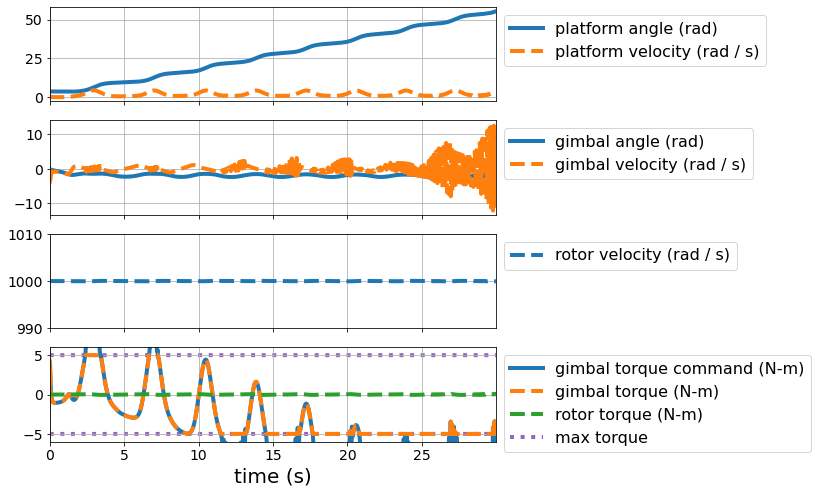

In [25]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_platform, ax_gimbal, ax_rotor, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot platform angle and velocity
ax_platform.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform.plot(
    data['t'], data['platform_velocity'],
    '--', label='platform velocity (rad / s)', linewidth=4,
)
ax_platform.grid()
ax_platform.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_platform.tick_params(labelsize=14)

# Plot gimbal angle and velocity
ax_gimbal.plot(
    data['t'], data['gimbal_angle'],
    label='gimbal angle (rad)', linewidth=4,
)
ax_gimbal.plot(
    data['t'], data['gimbal_velocity'],
    '--', label='gimbal velocity (rad / s)', linewidth=4,
)
ax_gimbal.grid()
ax_gimbal.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_gimbal.tick_params(labelsize=14)

# Plot rotor velocity
ax_rotor.plot(
    data['t'], data['rotor_velocity'],
    '--', label='rotor velocity (rad / s)', linewidth=4,
)
ax_rotor.grid()
ax_rotor.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_rotor.tick_params(labelsize=14)
ax_rotor.set_ylim(simulator.rotor_velocity - 10., simulator.rotor_velocity + 10.)

# Plot torques
ax_torque.plot(
    data['t'], data['gimbal_torque_command'],
    label='gimbal torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['gimbal_torque'],
    '--', label='gimbal torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['rotor_torque'],
    '--', label='rotor torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

fig.savefig('diverging_plot.png')
# Make the arrangement of subplots look nice
#fig.tight_layout()

Save the figure (without transparent background).

In [26]:
fig.savefig('diverging.png', facecolor='white', transparent=False)